# 📊 Visual Analysis of Dental Radiography Dataset

This notebook performs comprehensive exploratory analysis and visualization on the **Dental Radiography** dataset available at [Kaggle](https://www.kaggle.com/datasets/imtkaggleteam/dental-radiography).

---

## 📝 Dataset Description

The dataset contains dental radiograph images and corresponding YOLO-style annotations for various oral conditions (e.g., caries, crown, implants). It's suitable for object detection, image classification, and semantic segmentation tasks in dental AI applications.

---

## 🔍 Notebook Overview

### ✅ 1. Annotation Parsing & Preprocessing
- Load YOLO-format annotations using `label_parser.py`
- Group bounding boxes, detect duplicated labels per tooth, and filter single/multi-class images

### 📊 2. Class Distribution Analysis
- Use `class_stats_utils.py` to extract label counts and frequency of each class
- Visualize number of annotations and unique images per class in `train`, `val`, or `test` splits

### 🖼️ 3. Annotation Visualization
- Use `annotation_visualizer.py` to display bounding boxes:
  - Single-class examples
  - Multi-class images
  - Grouped teeth with overlapping annotations (multi-label situations)

### 📈 4. Ratio-Based Image Analysis
- Compute and visualize:
  - **Missing Teeth Ratio** from segmentation masks
  - **Darkness Ratio** from grayscale intensity
- Display histograms and heatmaps to explore data distribution

### 🧠 5. Semantic Segmentation with SegFormer
- Apply pretrained model `vimassaru/segformer-b0-finetuned-teeth-segmentation` via `segmentation_utils.py`
- Segment X-rays and visualize the teeth areas

### 🔬 6. Feature Embedding of Images & Masks (No Clustering)
- From `mask_clustering_analysis.py`:
  - Extract RGB color histograms
  - Apply **PCA**, **t-SNE**, and **UMAP** to obtain image-level embeddings
  - Visualize most distinct images along each embedding dimension

---

## 📌 Dataset Source

[Kaggle: Dental Radiography Dataset](https://www.kaggle.com/datasets/imtkaggleteam/dental-radiography)

---

## 📁 Code Modules

| File | Purpose |
|------|---------|
| `label_parser.py` | Parses YOLO annotations, groups teeth, checks label consistency |
| `class_stats_utils.py` | Extracts and visualizes class and image frequencies |
| `annotation_visualizer.py` | Shows annotated examples: single/multi-class and grouped boxes |
| `segmentation_utils.py` | Applies SegFormer model to X-ray images |
| `mask_clustering_analysis.py` | Embeds image and mask features via color histograms (no clustering) |


In [1]:
# 📦 Imports
import pandas as pd
from label_parser import load_annotations_csv, get_class_frequencies, filter_images_by_num_classes

# 📂 Path to annotations
csv_path = "/Volumes/L/L_PHAS0077/dental_radiography/train/_annotations.csv"

# 🔍 Load annotations and show label stats
df = load_annotations_csv(csv_path)

# 📊 Show class frequency
print("🔍 Class Frequency:")
print(get_class_frequencies(df))



🔍 Class Frequency:
Fillings          5242
Implant           1784
Cavity             576
Impacted Tooth     428
Name: count, dtype: int64


In [2]:
from annotation_visualizer import (
    visualize_single_class_examples,
    visualize_multi_class_examples,
    group_bounding_boxes,
    visualize_grouped_boxes
)

class_colors = {
        "Implant": "skyblue",         # Light and clear blue
        "Fillings": "lightgreen",     # Soft and distinguishable green
        "Impacted Tooth": "orange",   # Bright orange
        "Cavity": "purple"            # Strong and distinct purple
    }

main_path = '/Volumes/L/L_PHAS0077/dental_radiography/'
main_train_path = main_path + 'train'
file_path = main_train_path+'/_annotations.csv'


In [3]:
df_flat = []

for _, row in df.iterrows():
    for label, bbox in zip(row["Labels"], row["BBoxes"]):
        df_flat.append({
            "filename": row["Image"],
            "class": label,
            "xmin": bbox[0],
            "ymin": bbox[1],
            "xmax": bbox[2],
            "ymax": bbox[3]
        })

df_flat = pd.DataFrame(df_flat)

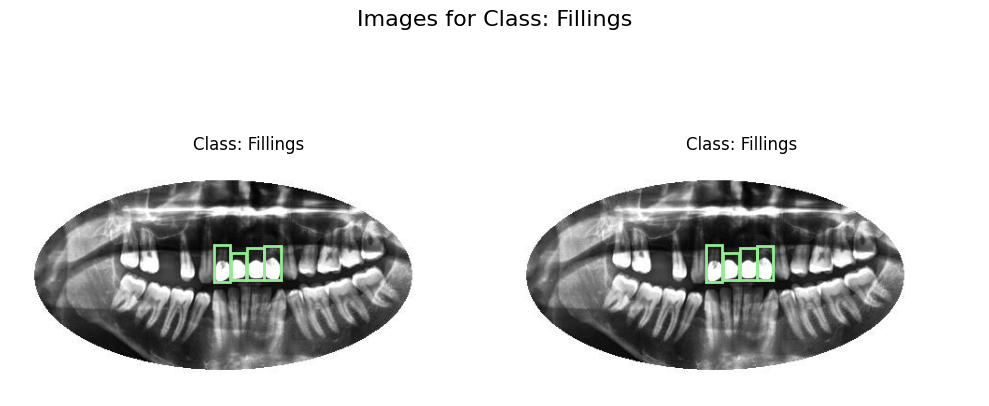

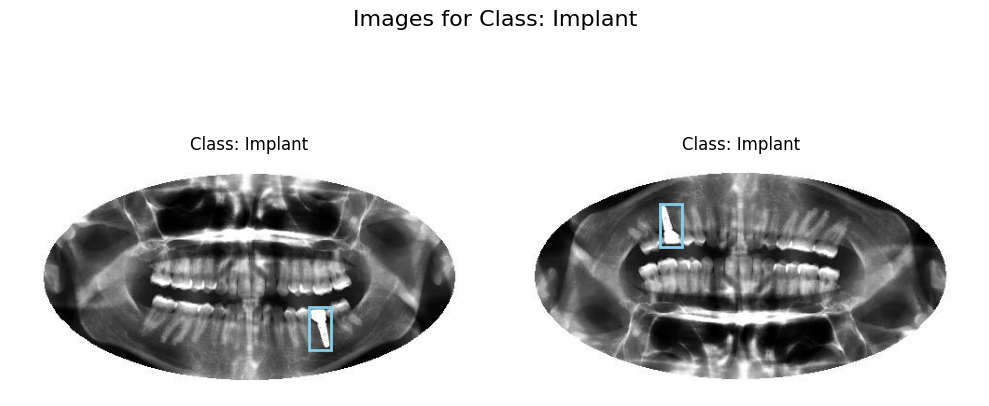

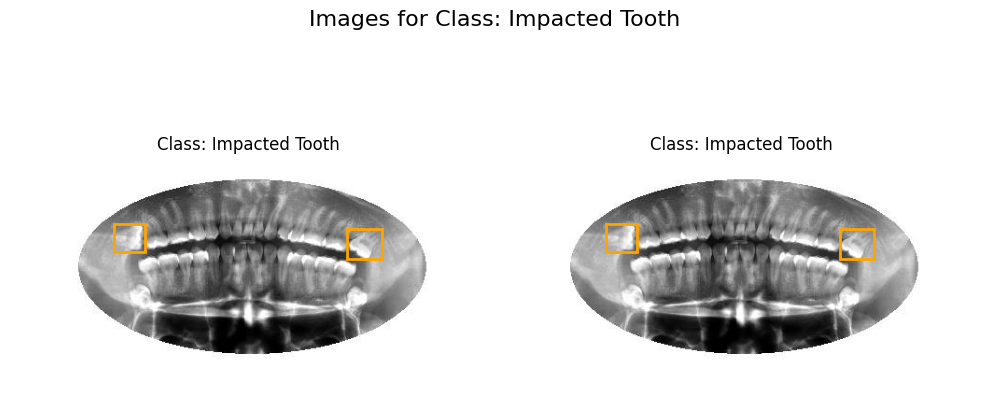

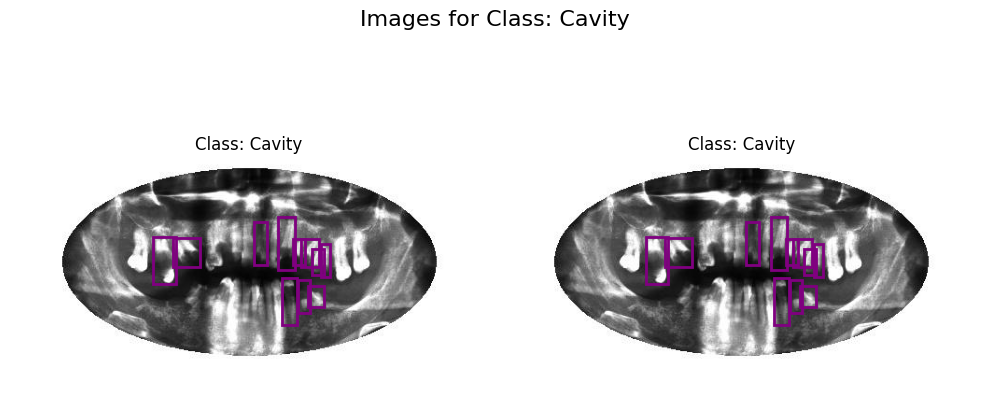

In [4]:
# Call each visualization as needed
visualize_single_class_examples(df_flat, main_train_path, class_colors)


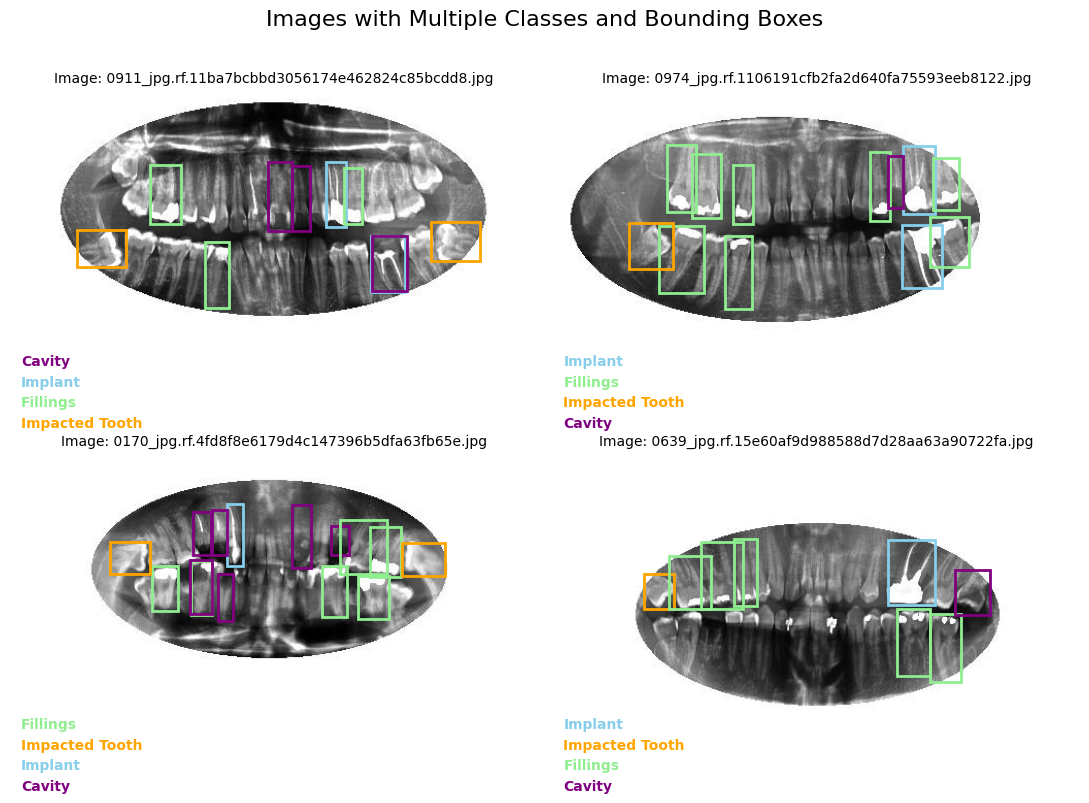

In [5]:


visualize_multi_class_examples(df_flat, main_train_path, class_colors, num_images_to_show=4)



📊 Pair Frequencies:
  ['Fillings', 'Impacted Tooth']: 11 image(s)
  ['Cavity', 'Fillings']: 26 image(s)
  ['Cavity', 'Implant']: 5 image(s)


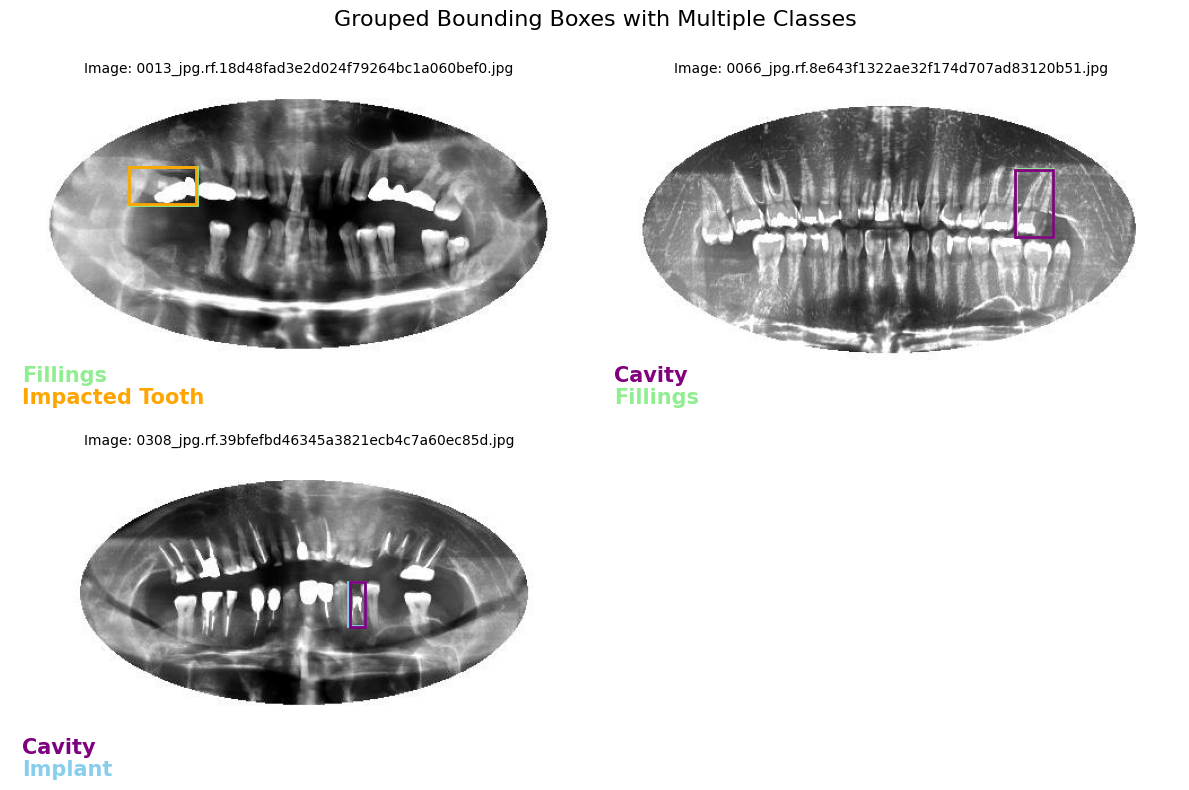

42 boxes with mutiple label.


In [6]:
grouped = group_bounding_boxes(df_flat, margin=1)
visualize_grouped_boxes(grouped[:], main_train_path, class_colors, unique_pairs_only=True)
print(f'{len(grouped)} boxes with mutiple label.')


📂 Folder: train
Total box count per class: [1784, 5242, 428, 576]
Image count per class     : [580, 863, 252, 230]


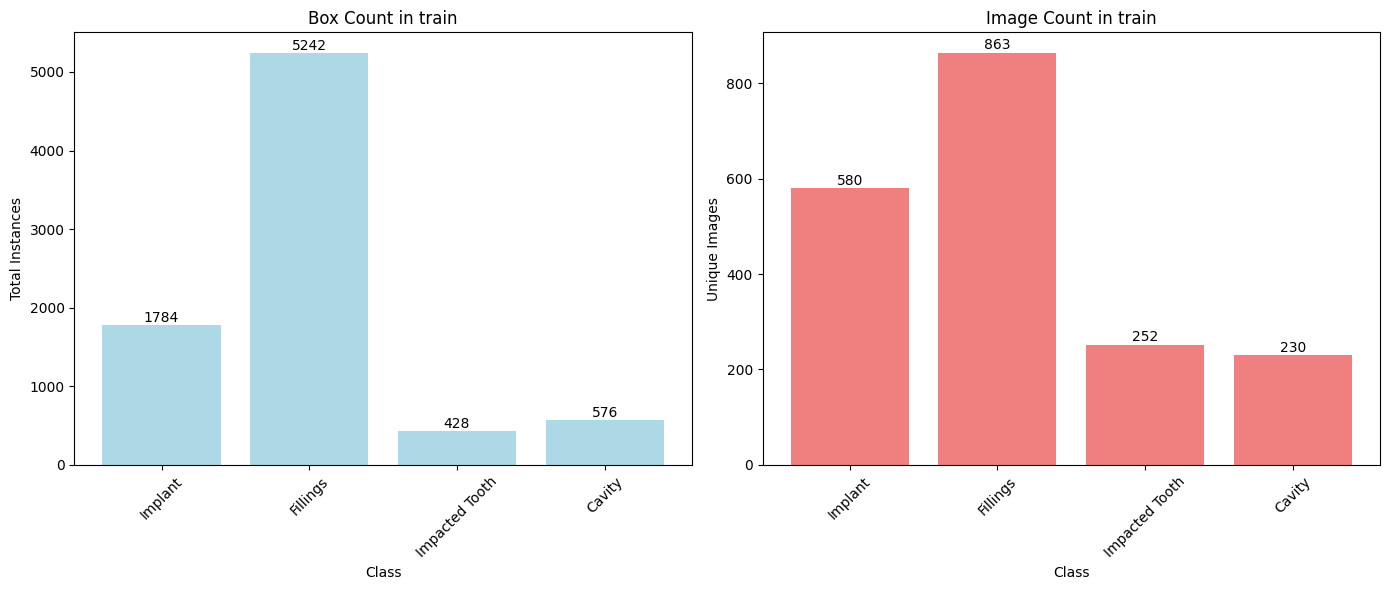


📂 Folder: test
Total box count per class: [104, 315, 32, 22]
Image count per class     : [31, 57, 17, 12]


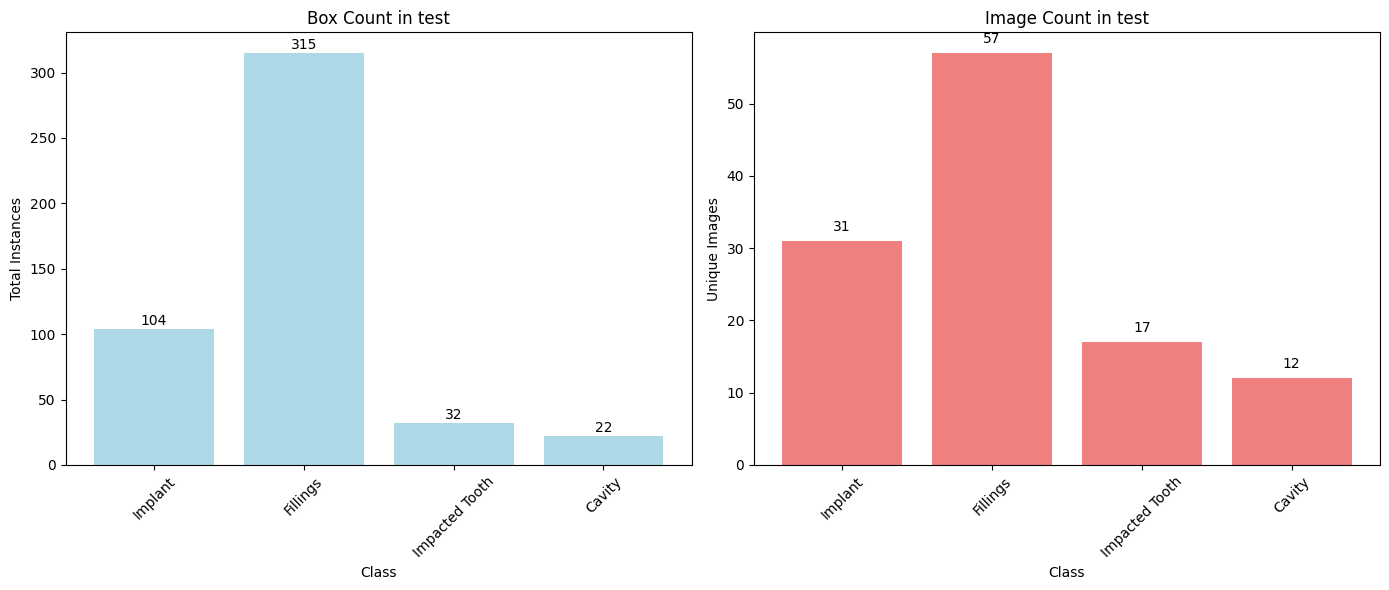


📂 Folder: valid
Total box count per class: [159, 540, 38, 43]
Image count per class     : [59, 97, 25, 23]


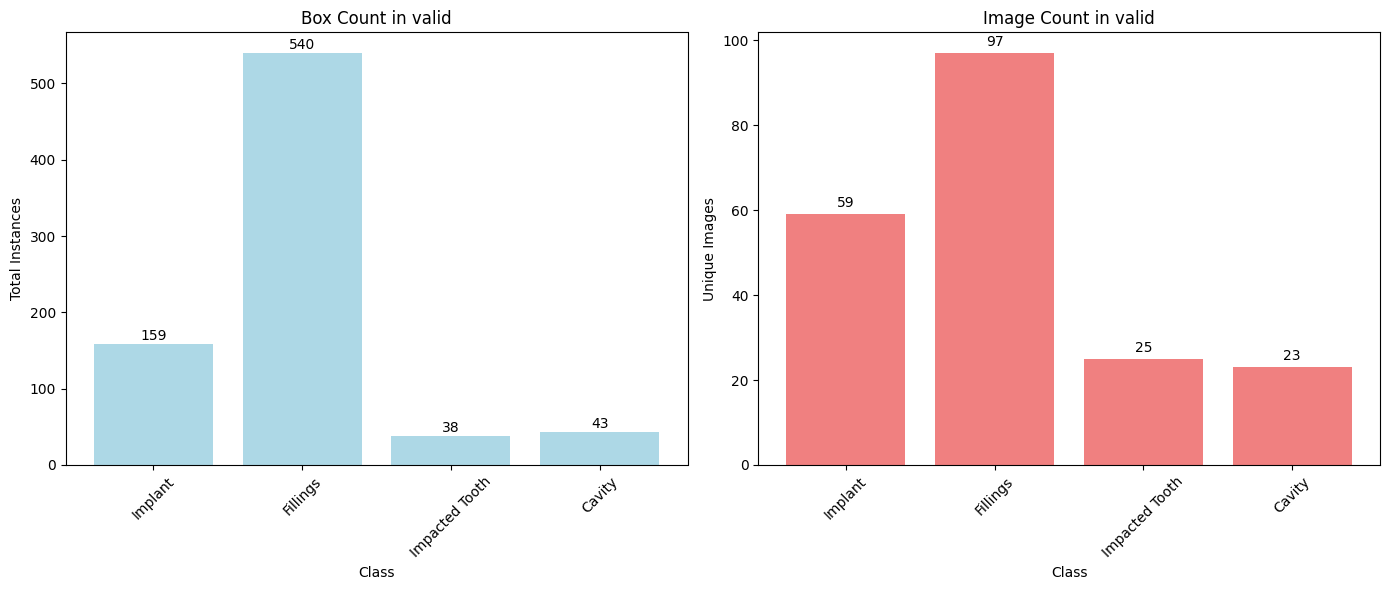

In [1]:
from class_stats_utils import (
    extract_csv_to_dataframe,
    count_classes_and_images,
    plot_class_distribution
)

# Step 1: Load all CSVs
dataframes = extract_csv_to_dataframe("/Volumes/L/L_PHAS0077/dental_radiography")

# Step 2: Count class statistics
class_counts = count_classes_and_images(dataframes)

# Step 3: Plot class distribution
fixed_class_order = ["Implant", "Fillings", "Impacted Tooth", "Cavity"]
plot_class_distribution(class_counts, fixed_class_order)


## 🧠 SegFormer for Teeth Segmentation

In this section, we use a pretrained **SegFormer-B0** model fine-tuned on dental imagery for **semantic segmentation of teeth**.

The model used is:

```python
AutoModelForSemanticSegmentation.from_pretrained("vimassaru/segformer-b0-finetuned-teeth-segmentation")
```

We apply it to X-ray images to segment regions containing teeth. This step is helpful for preprocessing, analysis, and focusing attention on relevant anatomical structures. The predictions are visualized as segmentation masks using a colormap.

🔗 **Model source**: [vimassaru/segformer-b0-finetuned-teeth-segmentation](https://huggingface.co/vimassaru/segformer-b0-finetuned-teeth-segmentation)

📁 **Code**: See attached file [`segmentation_utils.py`](sandbox:/mnt/data/segmentation_utils.py)


/Users/hananalaskar/miniforge3/envs/yolov11_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦷 Processing: 0001_jpg.rf.30a42966fb9c51553f6949b70234218d.jpg


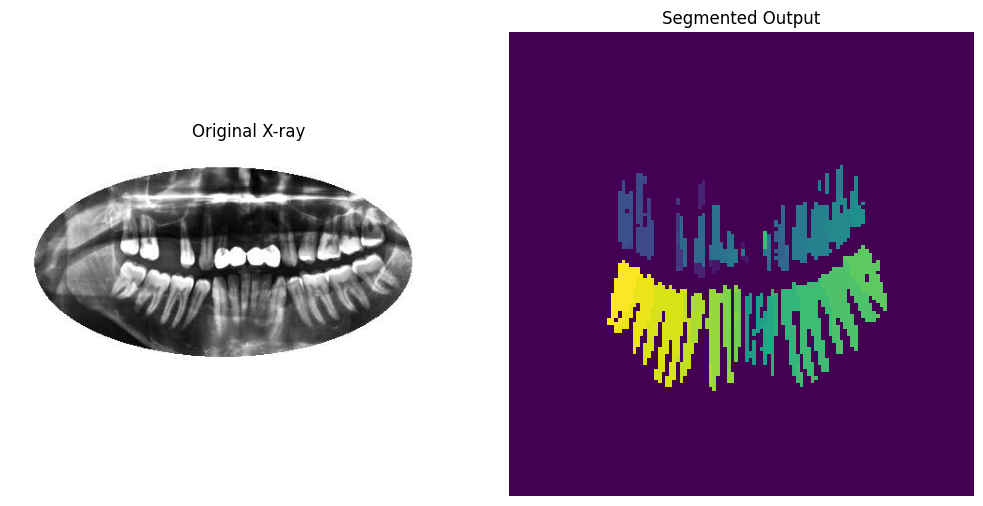

✅ Saved: assets/segformer_outputs/0001_jpg.rf.30a42966fb9c51553f6949b70234218d_segformer_result.png
🦷 Processing: 0001_jpg.rf.57229a11e925669019e179341e22c97a.jpg


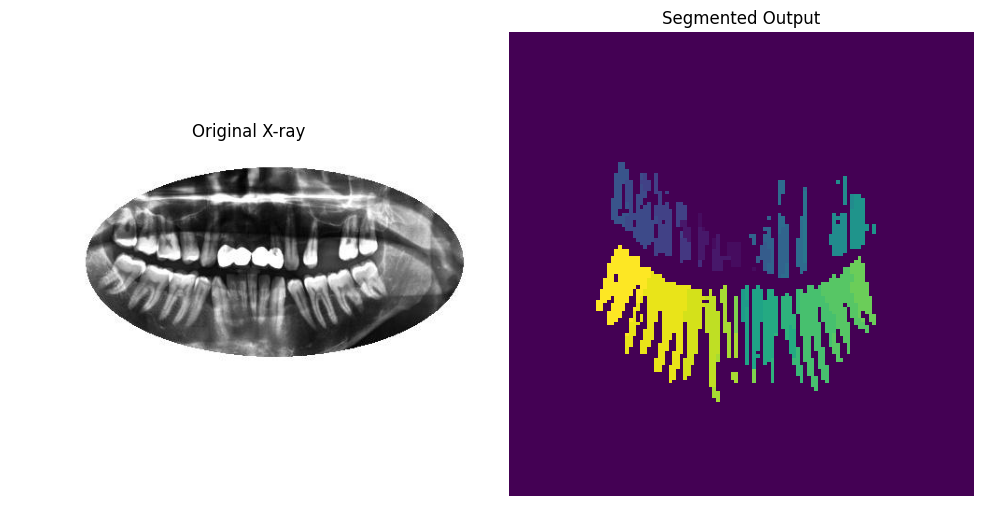

✅ Saved: assets/segformer_outputs/0001_jpg.rf.57229a11e925669019e179341e22c97a_segformer_result.png
🦷 Processing: 0001_jpg.rf.f94abcb7858bb419a7202ef60ef95bd6.jpg


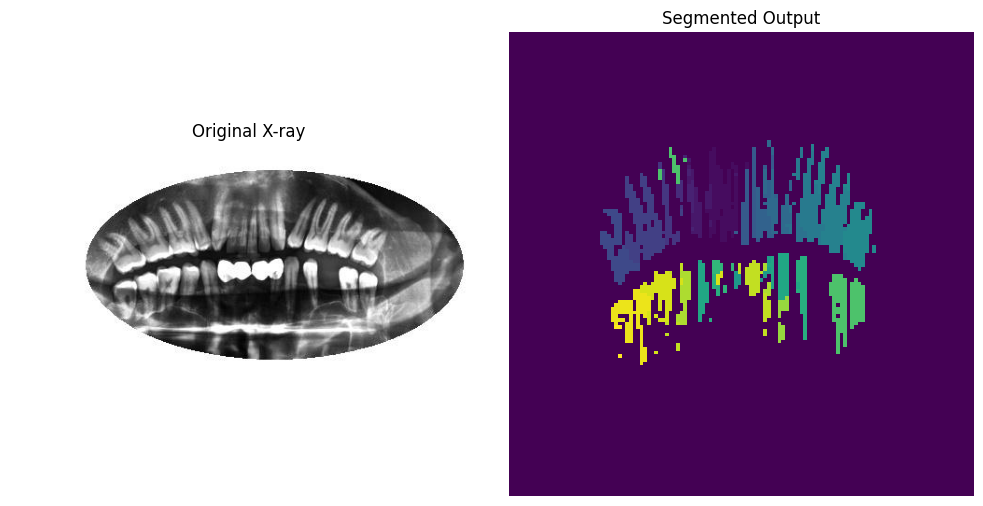

✅ Saved: assets/segformer_outputs/0001_jpg.rf.f94abcb7858bb419a7202ef60ef95bd6_segformer_result.png


In [8]:
from segmentation_utils import batch_infer_and_save
from pathlib import Path



batch_infer_and_save(
    source_folder = "./assets/source_img",
    output_folder = "./assets/segformer_outputs",
    pattern="*.jpg",  
    max_images = 3
)


## 🧪 Feature Analysis of X-rays and Segmentation Masks

In this section, we perform feature-based analysis of **dental X-ray images** and their **segmentation masks** using color histograms.

### Key Steps

1. **Feature Extraction**: We compute normalized RGB histograms for each image and mask.
2. **Dimensionality Reduction**: Project histogram features using **PCA**, **t-SNE**, and **UMAP** to visualize and compare image-level variability.
3. **Visualization**: Identify and plot image extremes (Min, Mid, Max) across embedding axes.
4. **Ratio Metrics**: Calculate and visualize:
   - **Missing Teeth Ratio** (portion of image area not covered by teeth in the mask)
   - **Darkness Ratio** (portion of low-intensity pixels in the image)
5. **Joint Analysis**: Generate a 2D histogram to explore the correlation between the two ratios.

📁 **Code Source**: `mask_feature_analysis.py`

This analysis provides insight into the variability and visual characteristics of the dataset, helping inform preprocessing and model design decisions.


In [1]:
from mask_feature_analysis import *

/Users/hananalaskar/miniforge3/envs/yolov11_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# ⚙️ source & mask images using color histogram and GMM, save embeddings
df_images, df_masks, df_combined = run_mask_feature_analysis(
    source_folder="/Volumes/L/L_PHAS0077/assets/source_img",
    mask_folder="/Volumes/L/L_PHAS0077/assets/output_images_mask",
    output_dir="/Volumes/L/L_PHAS0077/yolo/explore_data/analysis_outputs",
)



Found 1269 source images and 1269 mask images.


/Users/hananalaskar/miniforge3/envs/yolov11_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


✓ CSVs saved to /Volumes/L/L_PHAS0077/yolo/explore_data/analysis_outputs


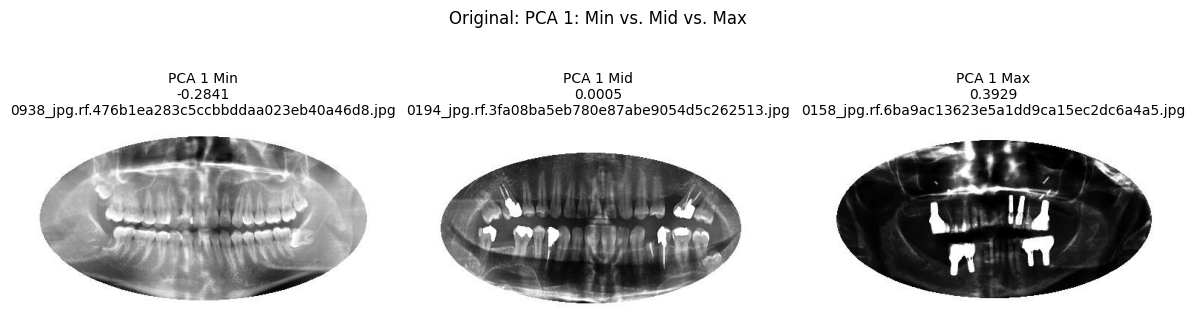

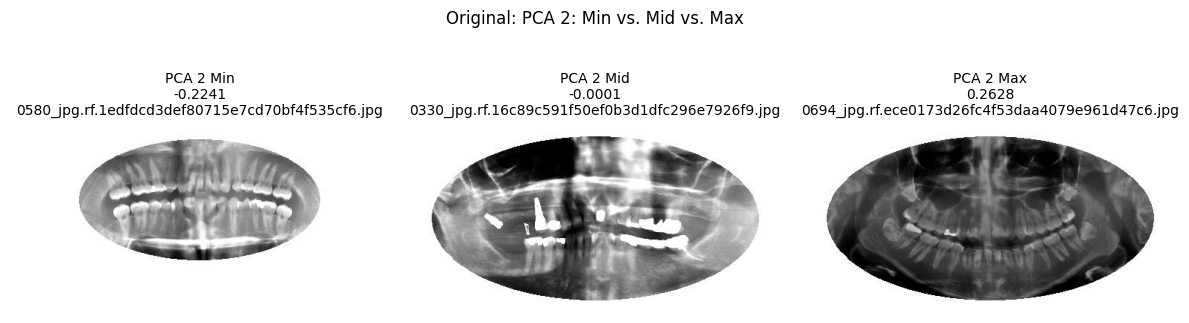

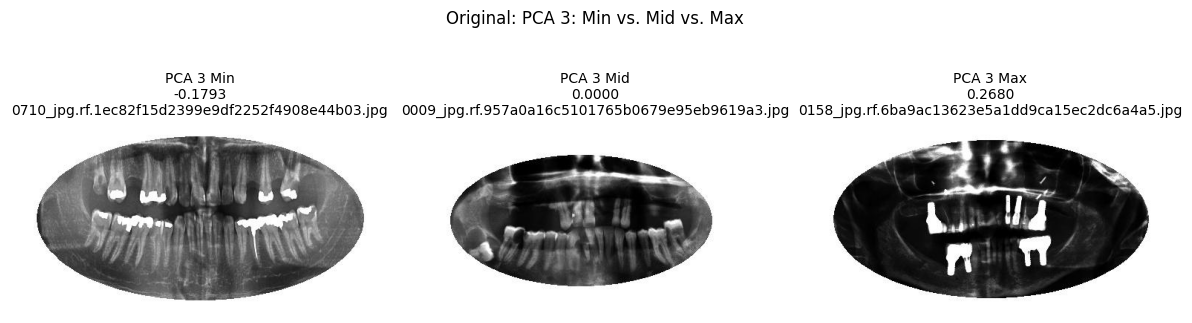

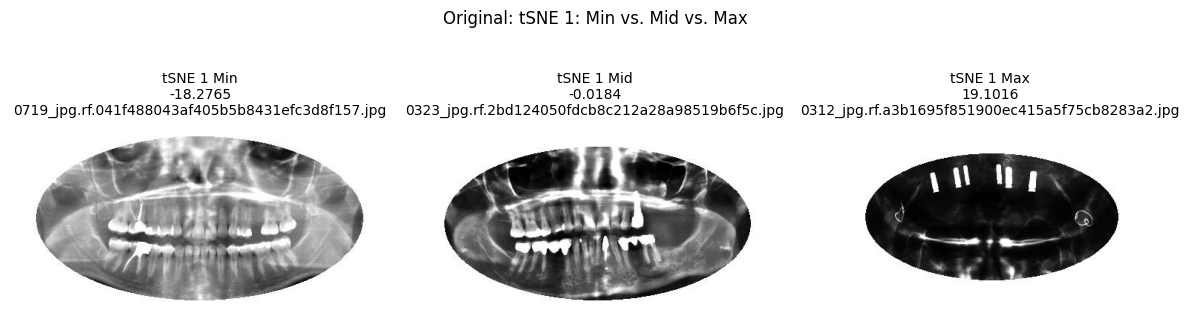

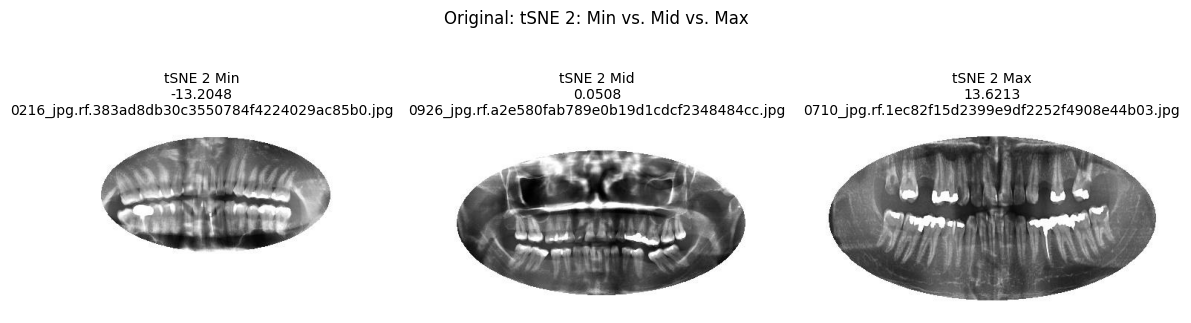

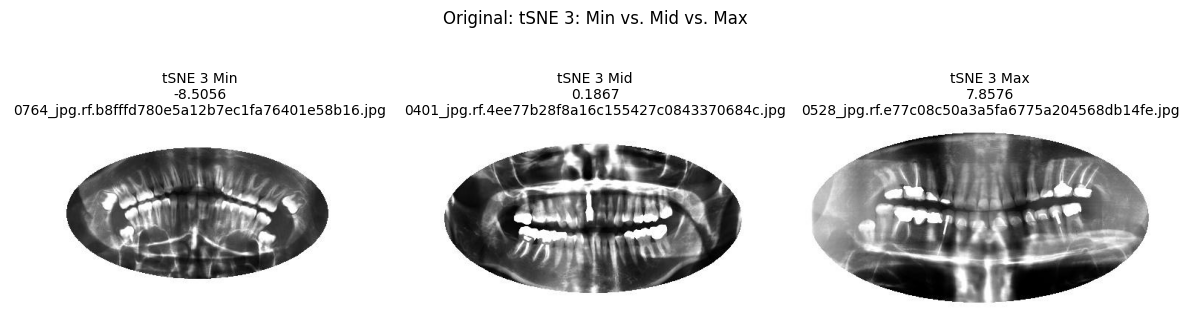

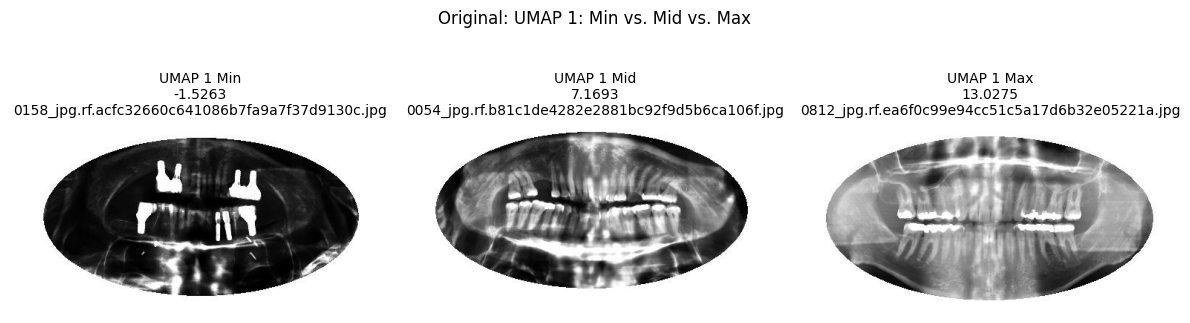

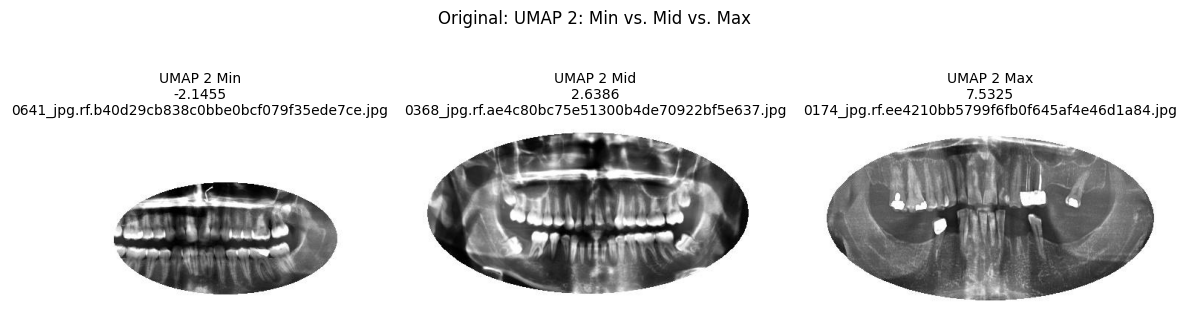

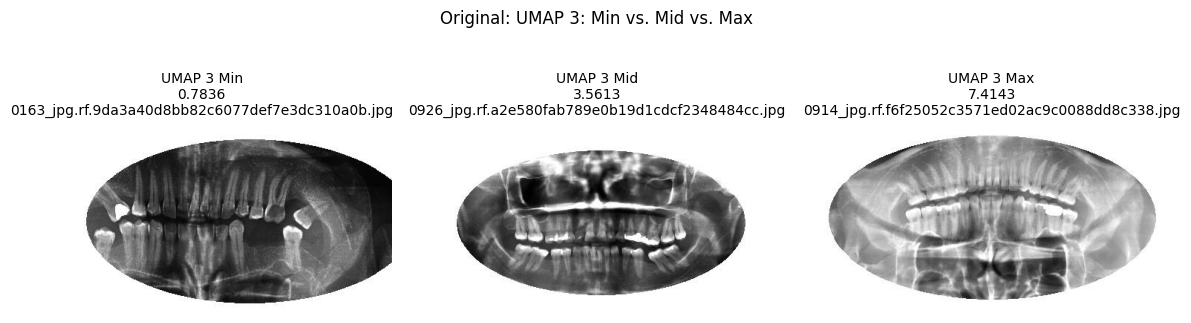

In [3]:


# Visualize
visualize_extremes(df_images, [
    "PCA 1", "PCA 2", "PCA 3", "tSNE 1", "tSNE 2", "tSNE 3", "UMAP 1", "UMAP 2", "UMAP 3"
], title_prefix="Original: ")

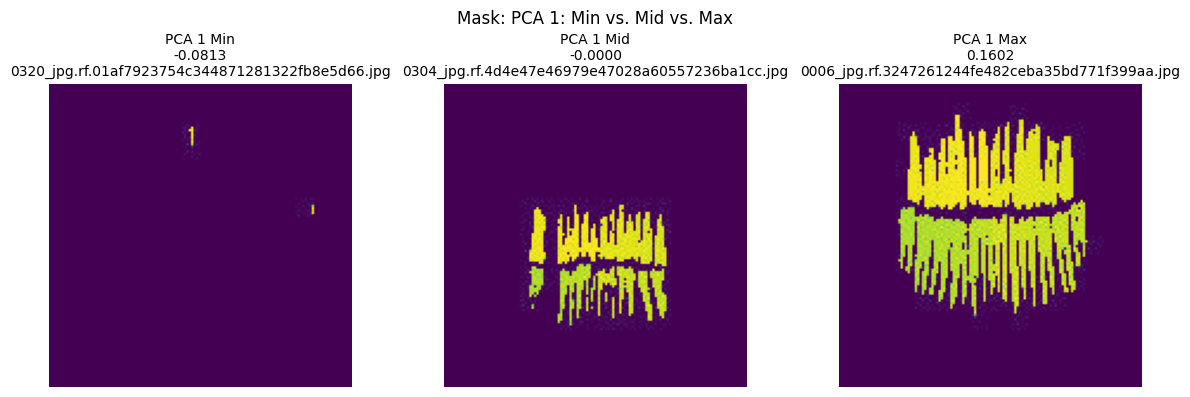

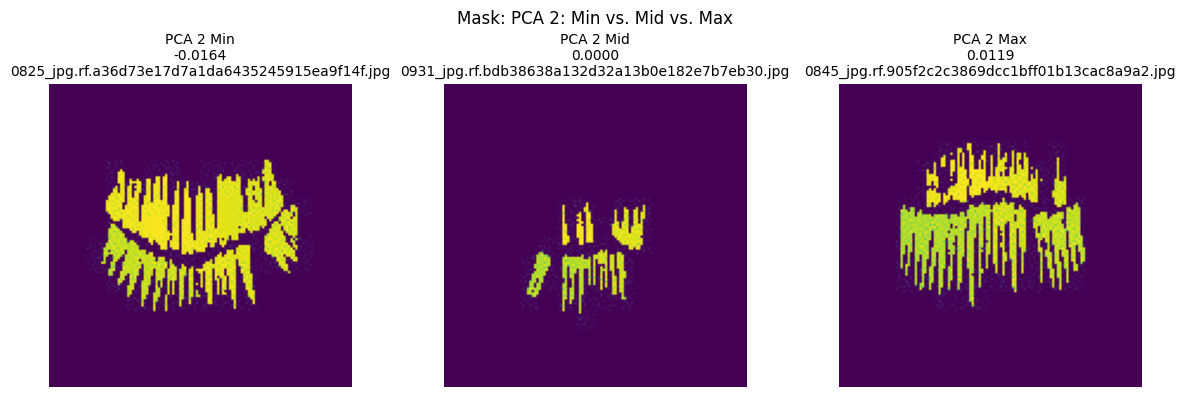

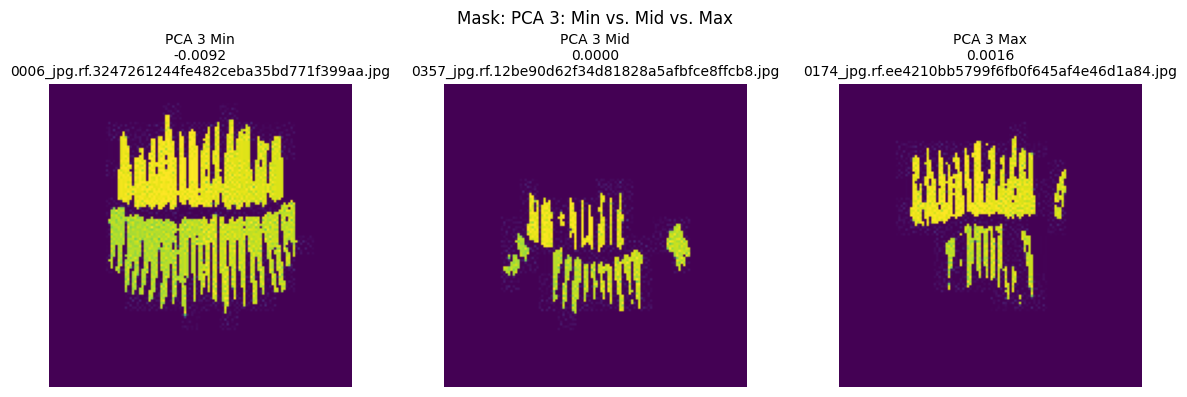

In [4]:
visualize_extremes(df_masks, ["PCA 1", "PCA 2", "PCA 3"], title_prefix="Mask: ")


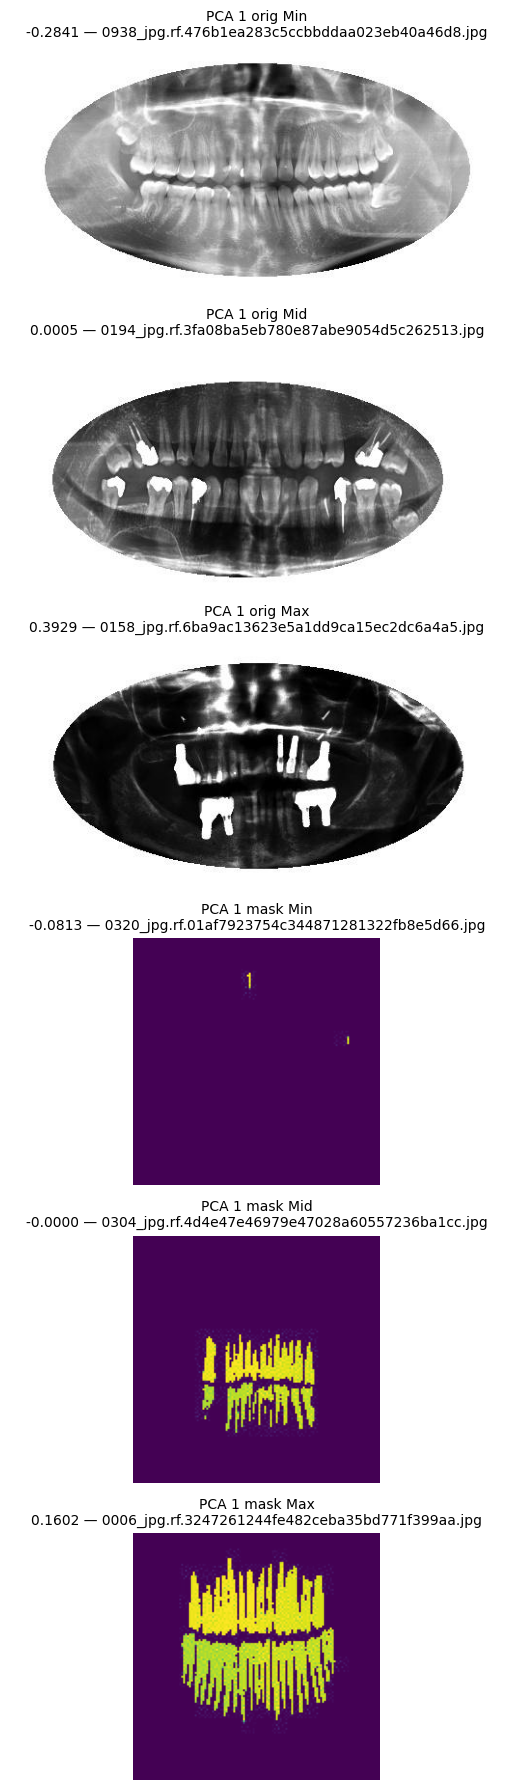

In [5]:
visualize_combined_pca(df_combined)


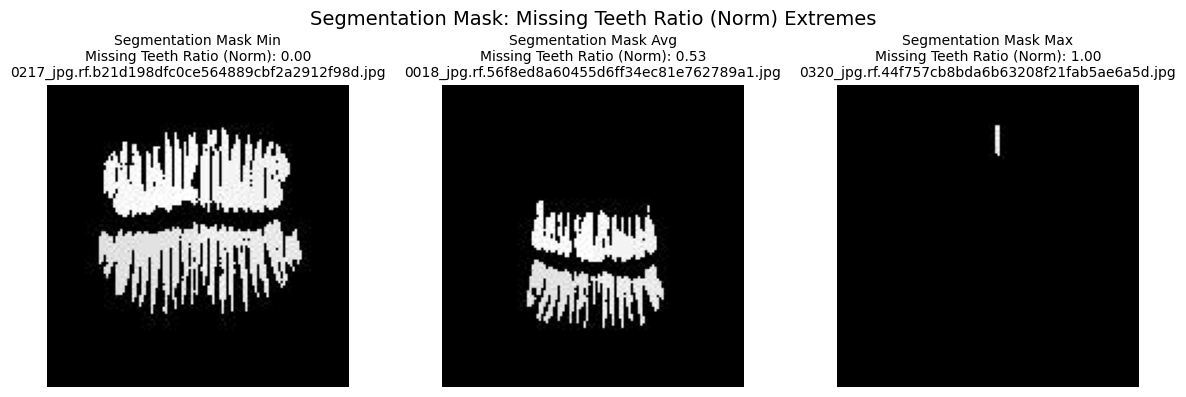

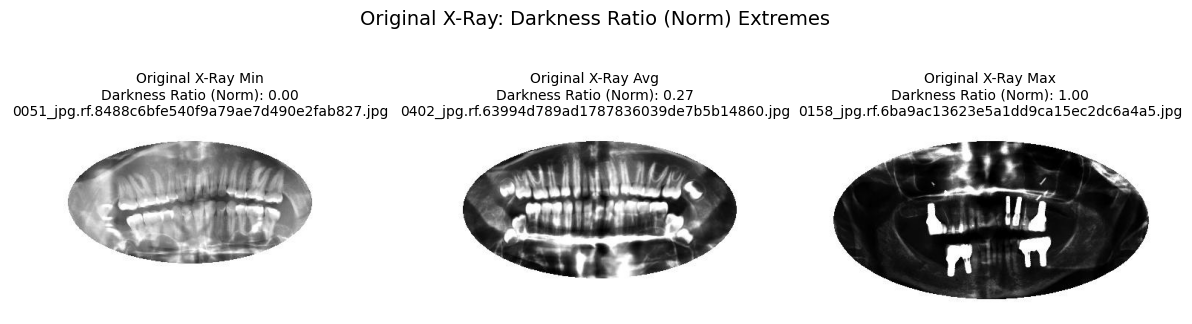

In [6]:


visualize_ratios(df_combined)


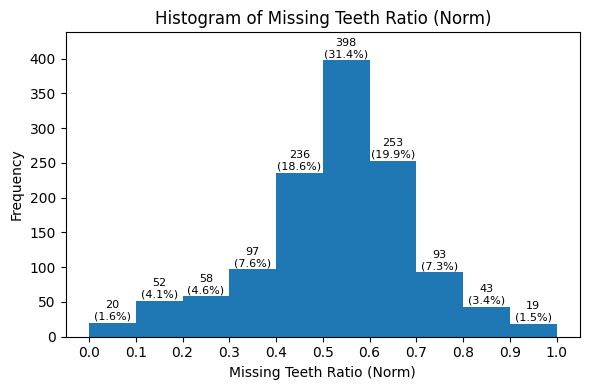

Saved histogram for Missing Teeth Ratio (Norm) at /Volumes/L/L_PHAS0077/analysis_outputs/missing_teeth_ratio_hist.png


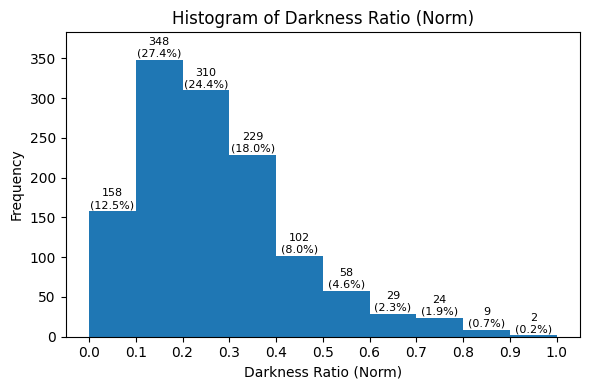

Saved histogram for Darkness Ratio (Norm) at /Volumes/L/L_PHAS0077/analysis_outputs/darkness_ratio_hist.png


In [7]:

save_ratio_histograms(df_combined, output_dir="/Volumes/L/L_PHAS0077/analysis_outputs")


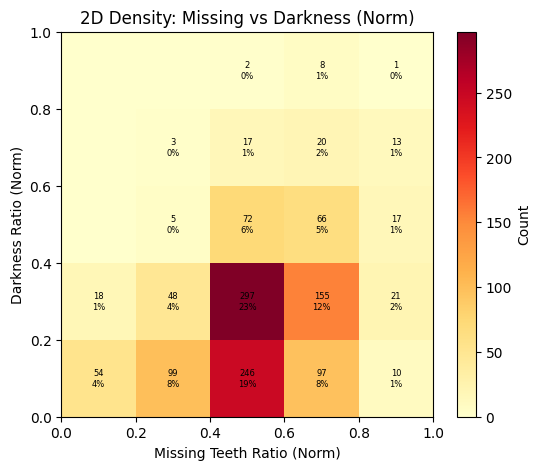

Saved joint-ratio heatmap at /Volumes/L/L_PHAS0077/analysis_outputs/missing_vs_darkness_heatmap.png


In [8]:
save_joint_ratio_heatmap(df_combined, output_dir="/Volumes/L/L_PHAS0077/analysis_outputs")
